# Polar Analysis 2
Test of electrical polarization following: <I>Müller-Caspary, Knut, et al. Physical Review Letters 122.10 (2019): 106102.</I>
<br>The PRL paper used an sub-A probe to do 4DSTEM and detect sub-UC momentum change, then average over unit cells using Voroni cell

In [2]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
import csv

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import scipy.io
import time
import glob,os
from scipy import optimize
from pylab import *


## Test on PZT film on LSMO

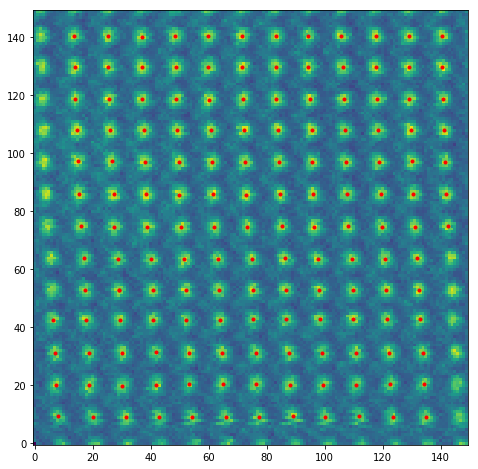

In [30]:
path = '/srv/home/chenyu/DEbackup/040219/S8/'

# Load COM file
COM = np.load(path + 'COM.npy')
COM_exp_mag = np.sqrt(COM[:,:,0]**2 + COM[:,:,1]**2)

# Load HAADF file
file_HAADF = [image for image in os.listdir(path) if '_Preview' in image]
file_HAADF = file_HAADF[0]
with open(path +  file_HAADF) as csvfile:
    file=csv.reader(open(path+file_HAADF,'r'))
    n=[]
    for row in file:
        n.append(row)

HAADFarray = np.transpose(np.asarray(n))
HAADFarray = np.squeeze(HAADFarray)
HAADFarray = HAADFarray.astype(np.float)
HAADFarray = np.reshape(HAADFarray,(150,150))
# HAADFarray = np.transpose(HAADFarray)

# Refine positions of peaks
im = img_as_float(HAADFarray,(150,150))
image_max = ndi.maximum_filter(im, size=25, mode='constant')
coordinates = peak_local_max(im, min_distance=7)

peaks_x_fit = []
peaks_y_fit = []
for i in range(coordinates.shape[0]):
    
    x = int(coordinates[i][1])
    y = int(coordinates[i][0])
    
    patch = im[y-7:y+7,x-7:x+7]
    patch = patch - amin(patch)
    bg = 0
    
    # parameters are in the order of : background, height, cx, cy, wx, wy
    guess = (bg,patch[7,7]-bg,7, 7, 3, 3)
    bounds = ([0,0,0,0,1,1],[np.inf,np.inf,14,14,10,10])
    param = fitGaussianx2(patch, guess, bounds)
    
    peaks_x_fit.append(param[2]+x-7)
    peaks_y_fit.append(param[3]+y-7)
    
fig = plt.figure(figsize=(8,8))
plt.imshow(HAADFarray,origin='lower')
# plt.scatter(coordinates[:,1],coordinates[:,0])
plt.plot(peaks_x_fit, peaks_y_fit,'r.')

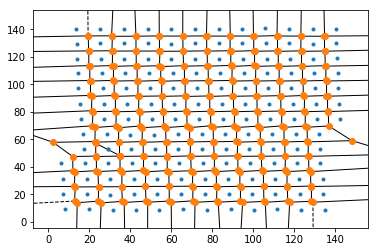

156

In [31]:
# Build Voroni cells
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(np.transpose(np.asarray([peaks_x_fit, peaks_y_fit])))
voronoi_plot_2d(vor)
plt.show()
len(vor.regions)

In [22]:
# Refine detected Voroni polygons, remove all the ones that contains border, i.e. vor.regions contain -1, empty cell, 
# cell with negative border, cell with border over pixel range

i = 0
while i != len(vor.regions):
    if -1 in vor.regions[i] or not vor.regions[i] or not all(vor.vertices[vor.regions[i]]>0) or not all(vor.vertices[vor.regions[i]]<150):
        del vor.regions[i]
    else:
        i = i+1
    

In [23]:
# Extract pixels within each Voroni cell
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# Very inefficient way to loop over all Voroni polygons for each pixel
# Not sure how to quickly find all pixels within each polygon
# https://stackoverflow.com/questions/36399381/whats-the-fastest-way-of-checking-if-a-point-is-inside-a-polygon-in-python
# Construct nx-by-ny px image with integers, each integer marks a voroni polygon

voroni_idx = np.zeros((150,150))

for irow in range(150):
    for icol in range(150):
        point = Point(icol,irow) # shapely.geomerty.Point is in the order of (x,y), thus (icol, irow)
        for ipolygon in range(len(vor.regions)):
            
            # vor.regions contains indices of points that form the polygon
            # vor.vertices contains coordinates of all points that are used to form Voroni polygons
            polygon = Polygon(vor.vertices[vor.regions[ipolygon]])
            
            if polygon.contains(point) is True:
                
                voroni_idx[irow,icol] = ipolygon+1
        

In [25]:
# Recalculate COM shift with symmetric ROI from reference point
rx = 150
ry = 150
kx = 512
ky = 512
ref = np.load('/srv/home/chenyu/DEbackup/040219/BlankCOM_APT70.npy')
ExpName = 'S8'
COM_exp = np.zeros((rx,ry,2))
kx = np.linspace(0,kx-1,kx)
ky = np.linspace(0,ky-1,ky)
weights_x, weights_y = np.meshgrid(kx,ky)

for ix in range(rx):
    for iy in range(ry):
        filenum = ix*rx+iy+1
        ref_x = ref[ix,iy,0]
        ref_y = ref[ix,iy,1]
        mask = create_circular_mask(512,512, center=[ref_x,ref_y], radius=min(ref_x,ref_y,511-ref_x,511-ref_y))
        frame = np.load(path+'npy/'+ExpName+'_'+format(filenum,'05')+'.npy')
        COM_exp[ix,iy,0] = np.average(weights_x,weights = frame*mask)
        COM_exp[ix,iy,1] = np.average(weights_y,weights = frame*mask)

COM_exp = COM_exp - ref
np.save(path + 'COM_refine.npy',COM_exp)

In [26]:
# Extract momentum transfer and real space COM for each voroni polygon
# For this dataset, diffraction x-y is almost aligned with image edges, thus COM movement along x,y can be directly interpreted as polar

# Save information of each Voroni polgon inside a n-by-4 matrix, each row contains cx, cy, COMx, COMy
voroni_list = np.zeros((int(np.amax(voroni_idx)), 4))
voroni_x = np.zeros((rx,ry))
voroni_y = np.zeros((rx,ry))
for i in range(int(np.amax(voroni_idx))):
    pixels = np.where(voroni_idx == i+1)
    voroni_list[i,0] = np.average(pixels[0])   # row index
    voroni_list[i,1] = np.average(pixels[1])   # col index
    voroni_list[i,2] = np.average(COM[pixels[0],pixels[1],0])
    voroni_list[i,3] = np.average(COM[pixels[0],pixels[1],1])
    voroni_x[pixels] = voroni_list[i,2]
    voroni_y[pixels] = voroni_list[i,3]

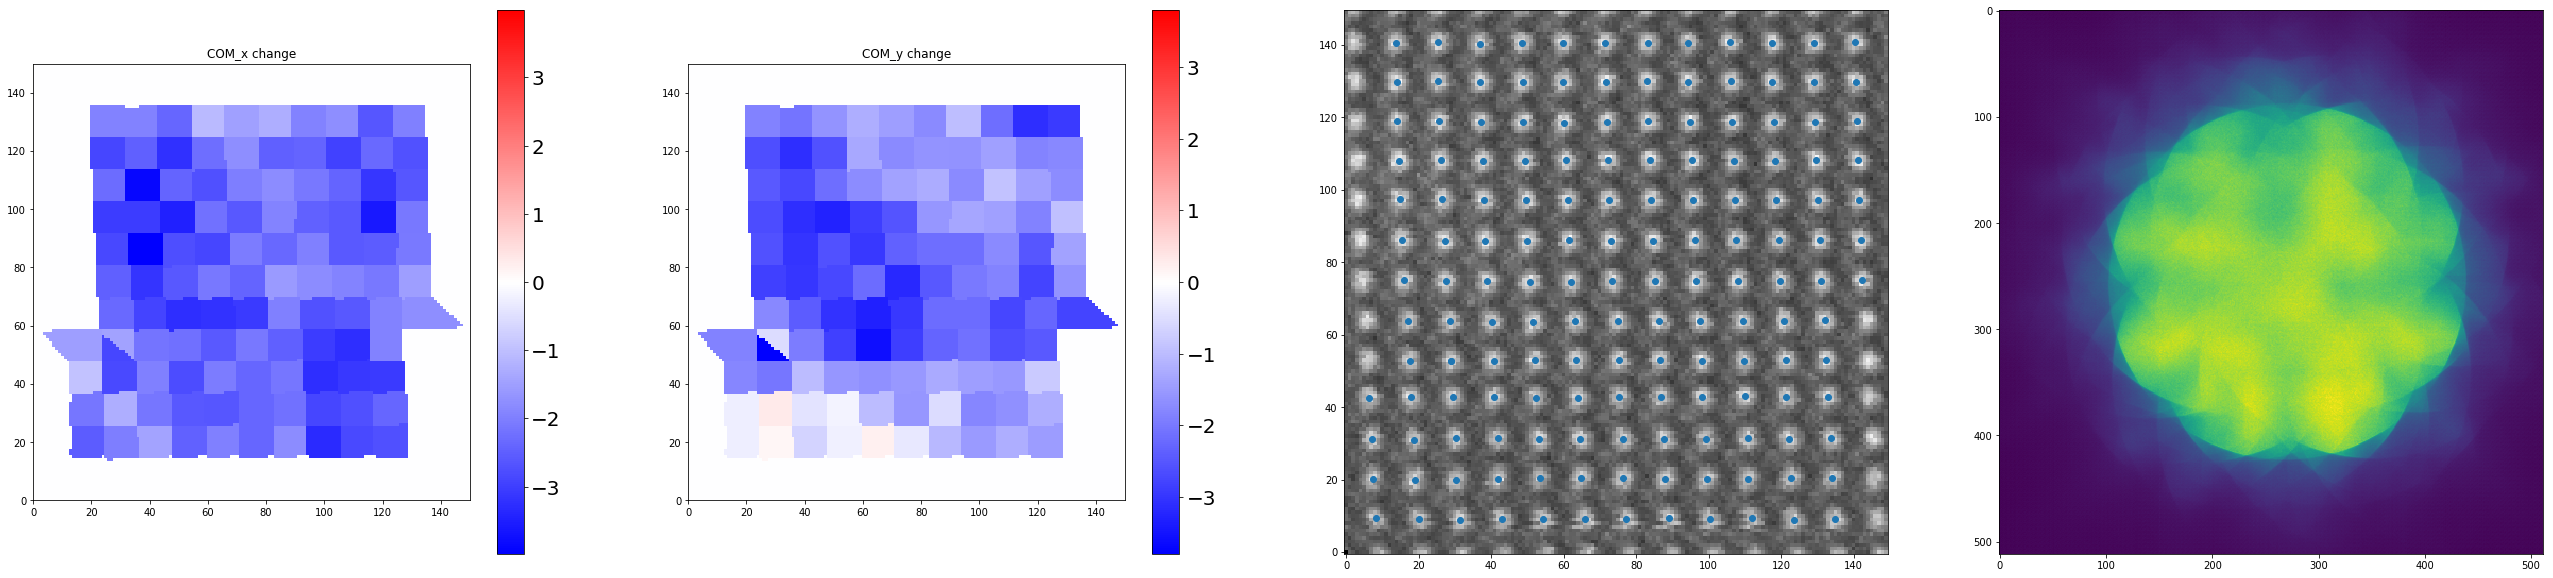

In [38]:
fig = plt.figure(figsize=(45,10))
fig.add_subplot(1,4,1)
plt.imshow(voroni_x,cmap=plt.cm.bwr,clim=[-amax(abs(voroni_x)),amax(abs(voroni_x))])
plt.title('COM_x change')
plt.xlim([0,150])
plt.ylim([0,150])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
# plt.axis('off')

fig.add_subplot(1,4,2)
plt.imshow(voroni_y,cmap=plt.cm.bwr,clim=[-amax(abs(voroni_y)),amax(abs(voroni_y))])
plt.title('COM_y change')
plt.xlim([0,150])
plt.ylim([0,150])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
# plt.axis('off')

fig.add_subplot(1,4,3)
plt.imshow((HAADFarray),cmap='gray',origin='lower')
plt.scatter(np.asarray(peaks_x_fit),np.asarray(peaks_y_fit))

fig.add_subplot(1,4,4)
plt.imshow(np.load(path + 'PACBED.npy'))

In [4]:
def gaussianx2(xdata_tuple,bg,height, center_x, center_y, width_x, width_y):

    (x, y) = xdata_tuple
    width_x = float(width_x)
    width_y = float(width_y)
    g = height*exp(
                 -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)+bg
    return g.ravel()

In [5]:
def fitGaussianx2(data, guess, bounds):
    x = np.linspace(0, data.shape[1]-1, data.shape[1])
    y = np.linspace(0, data.shape[0]-1, data.shape[0])
    x, y = np.meshgrid(x, y)
    xdata_tuple = (x,y)
    popt, pcov = optimize.curve_fit(gaussianx2, xdata_tuple, data.ravel(), p0=guess,bounds=bounds,method='trf',verbose=0,maxfev=100000)
    return popt

In [13]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

268.4546054831252 254.5953110511541


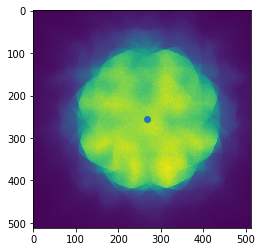

In [31]:
path = '/srv/home/chenyu/DEbackup/040219/S8/'
PACBED = np.load(path + 'PACBED.npy')

[kx,ky] = PACBED.shape
kx = np.linspace(0,kx-1,kx)
ky = np.linspace(0,ky-1,ky)
weights_x, weights_y = np.meshgrid(kx,ky)
COM_x = np.average(weights_x,weights=PACBED)
COM_y = np.average(weights_y,weights=PACBED)

plt.imshow(PACBED)
plt.scatter(COM_x,COM_y)
print(COM_x,COM_y)

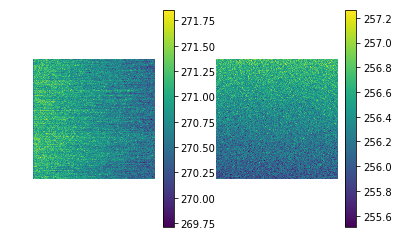

In [26]:
blankCOM = np.load('/srv/home/chenyu/DEbackup/040219/BlankCOM_APT70.npy')
plt.subplot(121)
plt.imshow(blankCOM[1:-1,:,0])
plt.axis('off')
plt.colorbar()

plt.subplot(122)
plt.imshow(blankCOM[1:-1,:,1])
plt.axis('off')
plt.colorbar()